**Chapter 3 – Classification**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/ai_ml/blob/main/030-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MNIST
In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and
employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the
“hello world” of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on
MNIST. 

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

In [9]:
28 * 28

784

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one
pixel’s intensity, from 0 (white) to 255 (black). Let's have a look at one digit. 

In [16]:
np.set_printoptions(linewidth=400)
X[0].reshape(28,28)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,  18.,  18.,  18., 126., 136.,

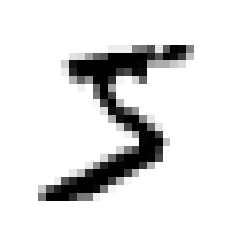

In [17]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [18]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [19]:
y = y.astype(np.uint8)

To give you a feel for the complexity of the classification task, next figure shows a few more images from the MNIST dataset.

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [2]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

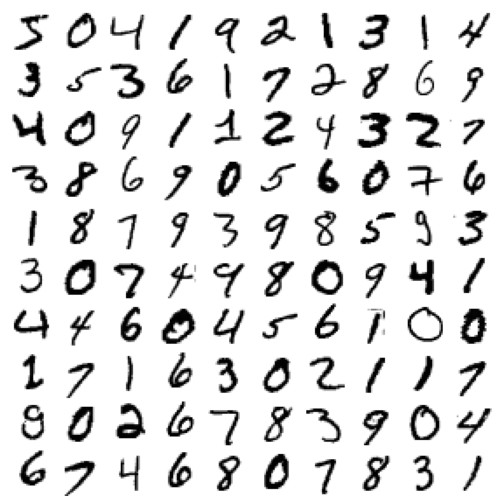

In [23]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

plt.show()

In [24]:
y[0]

5

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split
into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want
one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly
if they get many similar instances in a row.

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a _binary
classifier_, capable of distinguishing between just two classes, 5 and not-5.

In [27]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a _Stochastic Gradient Descent_ (SGD) classifier, using Scikit-Learn’s
`SGDClassifier` class. This classifier has the advantage of being **capable of handling very large datasets efficiently**. This is in part because SGD
deals with training instances independently, one at a time, which also makes SGD well suited for online learning. Let’s
create an `SGDClassifier` and train it on the whole training set:

**Note**: some hyperparameters will have a different default value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**TIP**  
The `SGDClassifier` relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state
parameter.

In [29]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s
performance.

# Performance Measures

## Measuring Accuracy Using Cross-Validation

Let’s use the `cross_val_score()` function to evaluate our SGDClassifier model, using K-fold cross-validation with three folds.
Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating
them on each fold using a model trained on the remaining folds (see Chapter 2):

In [30]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all crossvalidation folds? This looks amazing, doesn’t it? Well, before you get too
excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [34]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [35]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5,
you will be right about 90% of the time.  

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with
_skewed datasets_ (i.e., when some classes are much more frequent than others).

**Warning**: this output (and many others in this notebook and other notebooks) may differ slightly from those in the book. Don't worry, that's okay! There are several reasons for this:
* first, Scikit-Learn and other libraries evolve, and algorithms get tweaked a bit, which may change the exact result you get. If you use the latest Scikit-Learn version (and in general, you really should), you probably won't be using the exact same version I used when I wrote the book or this notebook, hence the difference. I try to keep this notebook reasonably up to date, but I can't change the numbers on the pages in your copy of the book.
* second, many training algorithms are stochastic, meaning they rely on randomness. In principle, it's possible to get consistent outputs from a random number generator by setting the seed from which it generates the pseudo-random numbers (which is why you will see `random_state=42` or `np.random.seed(42)` pretty often). However, sometimes this does not suffice due to the other factors listed here.
* third, if the training algorithm runs across multiple threads (as do some algorithms implemented in C) or across multiple processes (e.g., when using the `n_jobs` argument), then the precise order in which operations will run is not always guaranteed, and thus the exact result may vary slightly.
* lastly, other things may prevent perfect reproducibility, such as Python dicts and sets whose order is not guaranteed to be stable across sessions, or the order of files in a directory which is also not guaranteed.

## Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B.  In general, this is a much better way to evaluate the performance of a classifier.  

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. 

Since we don't touch the test set untill the very end of the project, we can use `cross_val_predict()` instead. 

In [36]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- Each _row_ in a confusion matrix represents an _actual class_
- Each _column_ represents a _predicted class_.  
- The first row of this matrix considers non-5 images: the _negative class_
    - 53.892 of them were correctly classified as non-5s: _true negatives_
    - the remaining 687 were wrongly classified as 5s: _false positives_
- The second row considers the images of 5s: the _positive class_ 
    - 1891 were wrongly classified as non-5s: _false negatives_
    - the remaining 3530 were correctly classified as 5s: _true positives_

A perfect classifier would have only true positives (TP) and true negatives (TN), so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall
- The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the _precision_ of the classifier.   

- _precision_ : the proportion of all samples that were predicted as positive which are really positive
$$    
P = \frac{TP}{TP + FP}
$$ 
A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this
would not be very useful, since the classifier would ignore all but one positive instance. 

So precision is typically used along with another metric
named _recall_, also called _sensitivity_ or the _true positive rate_ (TPR)
     
- _recall_ : the proportion of all positives which are correctly predicted
$$    
R = \frac{TP}{TP + FN}
$$

![](img/confmatrix.png)

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When it claims an image represents a 5, it is correct only 83.7% of the time. 

Moreover, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the _F<sub>1</sub> score_, in particular if you need a simple way to compare two classifiers.

$$
F_1 = 2\frac{P \cdot R}{P + R}
$$

The classifier will only get a high F<sub>1</sub> score score if both recall and precision are high.

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Trade-off

The _F<sub>1</sub> score_ favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example:
- if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your
product. 
- suppose you train a classifier to detect shoplifters in surveillance images: it is probably
fine if your classifier has only 30% precision as long as it has 99% recall
(sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. 
- It computes a score based on a _decision function_. 
- If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

![](img/precision-recall.png)

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

# Multiclass Classification

_Multiclass classifiers_ (also called _multinomial classifiers_) can distinguish between more than two classes. 

- Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively.
- Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. 
- However, there are various strategies that you can use to perform multiclass classification (classify the digit images into 10 classes (from 0 to 9)   with multiple binary classifiers.
    - _one-versus-the-rest (OvR)_ or _one versus-all_:  train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. 
    - _one-versus-one (OvO)_: train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, etc. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. __The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.__

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is
preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary
classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO,
depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the `sklearn.svm.SVC` class:

In [27]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the rest target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy:
it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

In [28]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

To evaluate this classifier, you can use cross-validation. Use the `cross_val_score()` function to evaluate the SGDClassifier’s accuracy:

**Warning**: the following two cells may take close to 30 minutes to run, or more depending on your hardware.

In [62]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still
do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89%:

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

To improve the model we analyze the types of errors it makes. 

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s `matshow()` function:

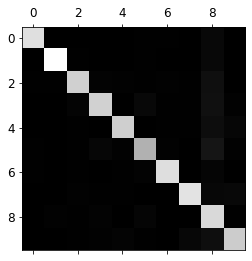

In [31]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class
so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [32]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # returns a 1-dimensional array with row totals
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

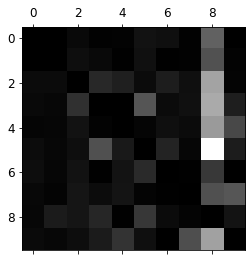

In [33]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that
bad, telling you that actual 8s in general get properly classified as 8s.
- 3s and 5s often get confused (in both directions).

Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. 
- try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. 
- engineer new features that would help the classifier
    - writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none)
- preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights on
what your classifier is doing and why it is failing

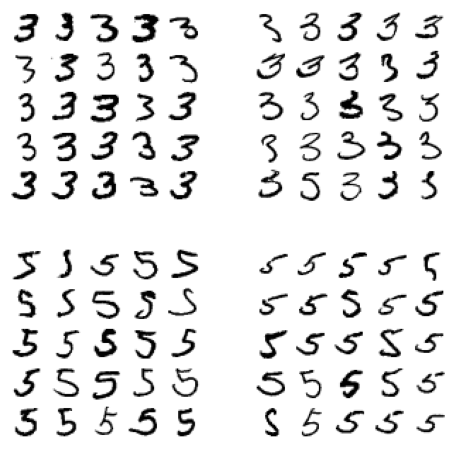

In [34]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks on the right show images classified as 5s. 
- Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 in the first row and second column truly looks like a badly written 3). 
- However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. 
- The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel